In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import scipy.stats


In [7]:
file_path = 'skyserver-checkpoint.csv'
# create a dtype_dict of the csv so the parsing skips type inference increasing speed
dtype_dict = {
    "class": "category",
    "u": "float64",      
    "g": "float64",
    "r": "float64",
    "i": "float64",
    "z": "float64",
    "redshift": "float64"
}

# due pandas being optimized with C code and multi-threading, using the pandas csv parser will be
# efficient than manually turning each row and column into its own numpy array. However, if the csv
# is small then the overhead brought upon by using pandas may cause pandas to not be as efficient.
df = pd.read_csv(file_path, dtype=dtype_dict)

# Separate data by class
star_data = df[df['class'] == 'STAR']
galaxy_data = df[df['class'] == 'GALAXY']
qso_data = df[df['class'] == 'QSO']

# Define features
features = ['u', 'g', 'r', 'i', 'z', 'redshift']

# Print stats header
print(f"{'':<10}{'u':<20}{'g':<20}{'r':<20}{'i':<20}{'z':<20}{'redshift':<20}")
print("-" * 130)
def stats_line(cls_name, cls_data):
    line = f"{cls_name:<10}"
    for f in features:
        mean_val = cls_data[f].mean()
        std_val = cls_data[f].std()
        line += f"{mean_val:.5f}±{std_val:.5f} | "
    return line

# Print stats for each class
print(stats_line("STAR", star_data))
print(stats_line("GALAXY", galaxy_data))
print(stats_line("QSO", qso_data))


          u                   g                   r                   i                   z                   redshift            
----------------------------------------------------------------------------------------------------------------------------------
STAR      18.33044±0.92982 | 17.13055±0.98846 | 16.73209±1.08090 | 16.59405±1.15215 | 16.53112±1.17191 | 0.00004±0.00041 | 
GALAXY    18.80434±0.69239 | 17.35022±0.75724 | 16.64951±0.84850 | 16.27277±0.88569 | 16.01792±0.94704 | 0.08033±0.04604 | 
QSO       18.94293±0.56921 | 18.67871±0.61499 | 18.49853±0.67328 | 18.36001±0.71998 | 18.27476±0.77445 | 1.21837±0.69770 | 


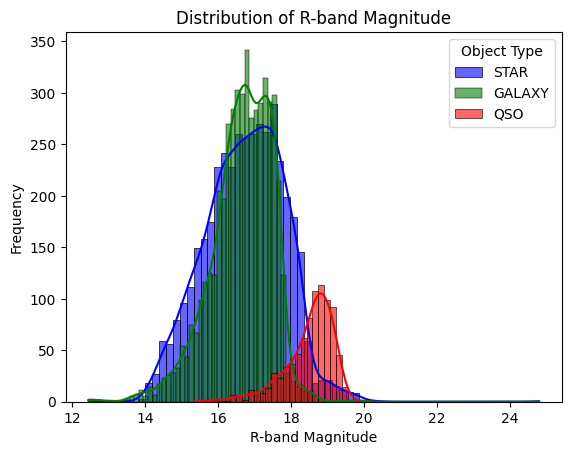

In [8]:
# Convert to numpy arrays for histogram fitting and confusion matrix calculations
star_r_arr = star_data['r'].values
galaxy_r_arr = galaxy_data['r'].values
qso_r_arr = qso_data['r'].values

# Histograms for 'r' feature
sns.histplot(star_data['r'], color='blue', label='STAR', kde=True, alpha=0.6)
sns.histplot(galaxy_data['r'], color='green', label='GALAXY', kde=True, alpha=0.6)
sns.histplot(qso_data['r'], color='red', label='QSO', kde=True, alpha=0.6)
plt.xlabel('R-band Magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of R-band Magnitude')
plt.legend(title='Object Type')
plt.show()

In [9]:
# Histogram fitting function
def histo(input_list):
    mu, sigma = norm.fit(input_list)
    bin_values, bins, _ = plt.hist(input_list, 30, range=(0, 30), edgecolor="k")
    plt.close()  # Close the figure since we are just fitting
    # Fit Gaussian
    gaus_func = lambda x, mu, sig, a: a * norm.pdf(x, loc=mu, scale=sig)
    centers = 0.5 * (bins[1:] + bins[:-1])
    pars, cov = curve_fit(gaus_func, centers, bin_values, p0=[16, 1, max(bin_values)])
    print(f'mu={pars[0]:.6f}, mu error={np.sqrt(cov[0,0]):.6f}, sigma={pars[1]:.6f}, sigma error={np.sqrt(cov[1,1]):.6f}')

# Gaussian fits for each class
print("Gaussian fits for STAR 'r':")
histo(star_r_arr)
print("Gaussian fits for GALAXY 'r':")
histo(galaxy_r_arr)
print("Gaussian fits for QSO 'r':")
histo(qso_r_arr)


Gaussian fits for STAR 'r':
mu=16.804036, mu error=0.029195, sigma=1.158780, sigma error=0.029200
Gaussian fits for GALAXY 'r':
mu=16.810199, mu error=0.021555, sigma=0.817166, sigma error=0.022398
Gaussian fits for QSO 'r':
mu=18.574180, mu error=0.010099, sigma=0.656552, sigma error=0.007439


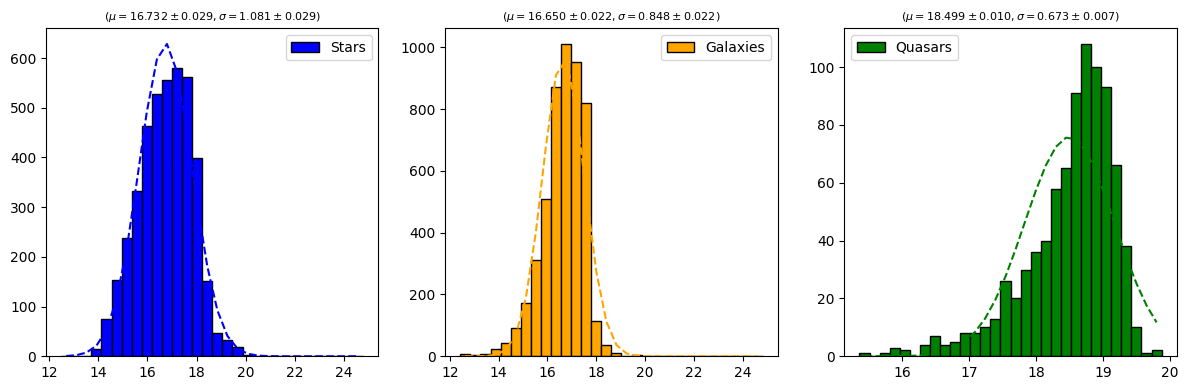

In [10]:
# Create subplots for r-feature distributions with fitted Gaussians
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
types_data = [star_r_arr, galaxy_r_arr, qso_r_arr]
types_colors = ['blue', 'orange', 'green']
labels = ['Stars', 'Galaxies', 'Quasars']
mu_errors = [0.029, 0.022, 0.010] 
sigma_errors = [0.029, 0.022, 0.007]

mu_data = []
sigma_data = []

for i, ax in enumerate(axs):
    types = types_data[i]
    color = types_colors[i]
    label = labels[i]
    n, bins, patches = ax.hist(types, label=label, color=color, bins=30, edgecolor='black')
    midpoints = 0.5 * (bins[1:] + bins[:-1])
    mu, sigma = norm.fit(types)
    mu_data.append(mu)
    sigma_data.append(sigma)
    bin_width = bins[1] - bins[0]
    best_fit_line = norm.pdf(midpoints, mu, sigma) * len(types) * bin_width
    ax.plot(midpoints, best_fit_line, color=color, linestyle='--')
    title_str = (f'($\mu={mu:.3f} \pm {mu_errors[i]:.3f}, '
                 f'\sigma={sigma:.3f} \pm {sigma_errors[i]:.3f}$)')
    ax.set_title(title_str, fontsize=8)
    ax.legend()

plt.tight_layout()
plt.show()

In [12]:
# Compute confusion matrix based on 1-sigma criteria
classes_arrays = [star_r_arr, galaxy_r_arr, qso_r_arr]
conf_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        within_1_sigma = np.logical_and(
            classes_arrays[j] >= mu_data[i] - sigma_data[i],
            classes_arrays[j] <= mu_data[i] + sigma_data[i]
        )
        conf_matrix[i, j] = np.sum(within_1_sigma)

conf_matrix = conf_matrix / np.array([len(star_r_arr), len(galaxy_r_arr), len(qso_r_arr)]).reshape(-1, 1)

print("Confusion Matrix:")
print(conf_matrix)

purity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
print("Purity:", purity)
print("Recall:", recall)

Confusion Matrix:
[[0.66979769 1.0267341  0.02938343]
 [0.44677871 0.71188475 0.01420568]
 [0.70588235 0.14588235 0.74705882]]
Purity: [0.3675242  0.37775765 0.94486913]
Recall: [0.38808261 0.60696008 0.46725533]


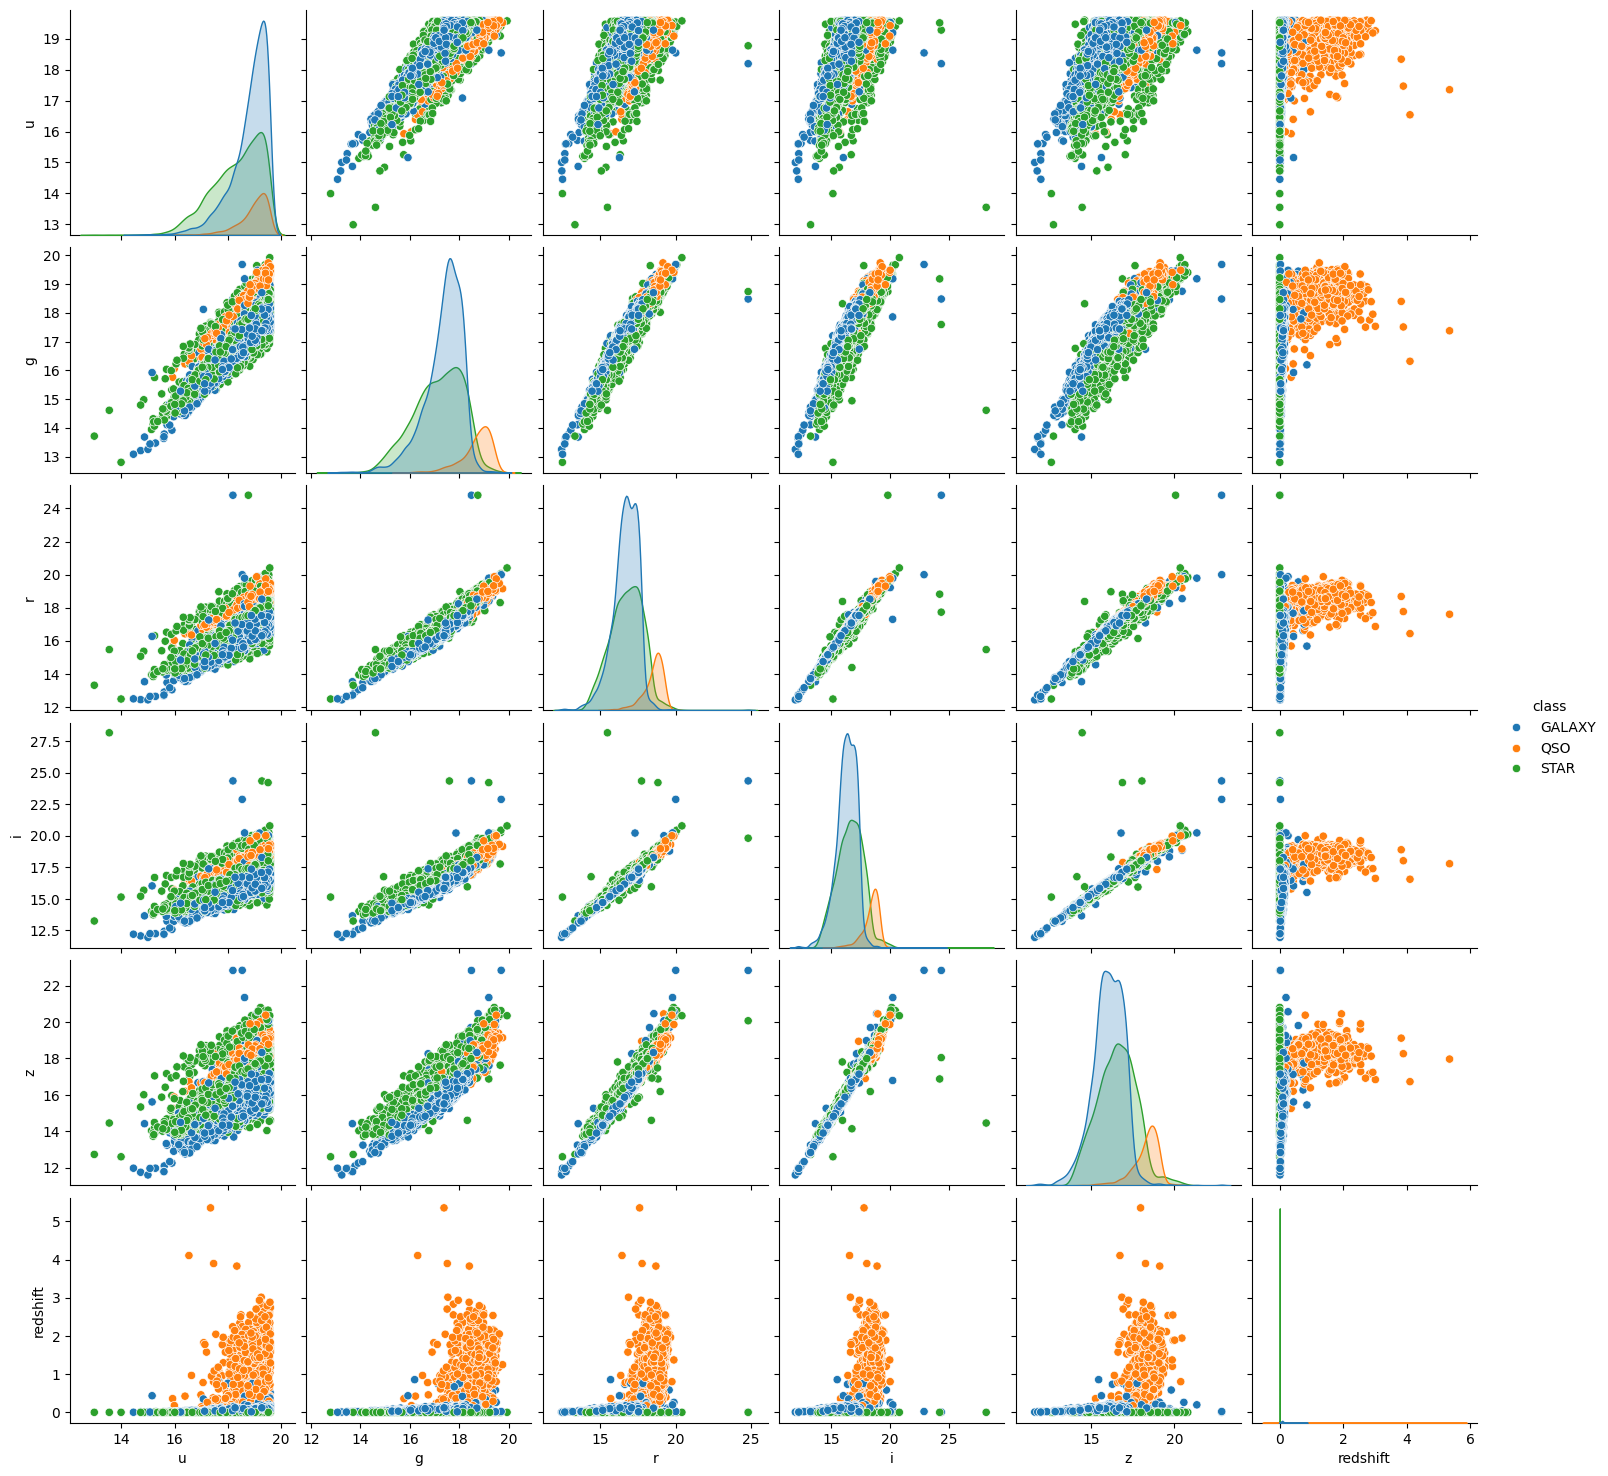

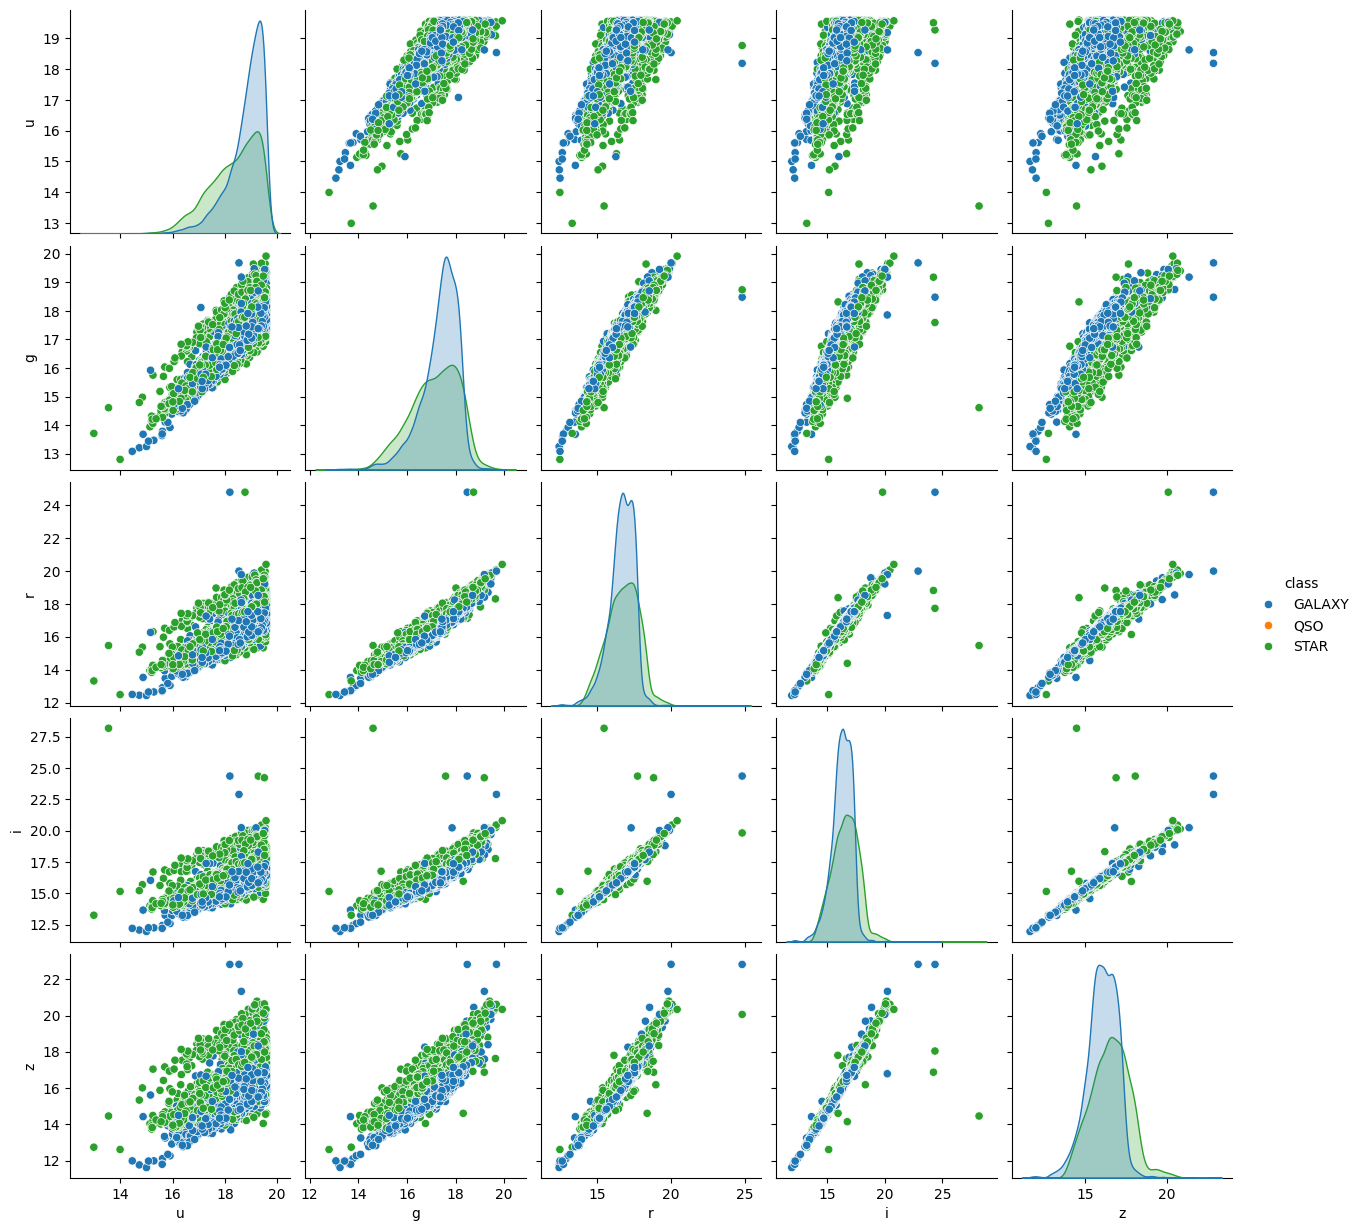

In [13]:
# Pairplot of entire dataset
sns.pairplot(df, hue='class')
plt.show()

temp_df = df[df['class'] != 'QSO']
temp_df = temp_df.drop('redshift', axis=1)
sns.pairplot(temp_df, hue='class')
plt.show()

Accuracy: 0.9750874125874126


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


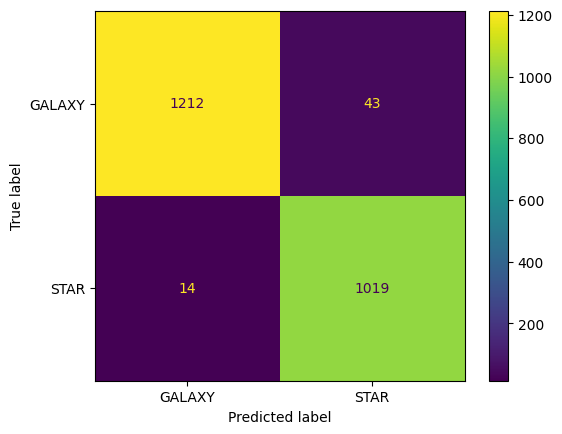

In [14]:
# Prepare data for MLPClassifier
X_temp = temp_df.drop('class', axis=1)
y_temp = temp_df['class']

Xtrain, Xtest, ytrain, ytest = train_test_split(X_temp, y_temp, random_state=1)
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

print("Accuracy:", accuracy_score(ytest, y_model))

cm = confusion_matrix(ytest, y_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

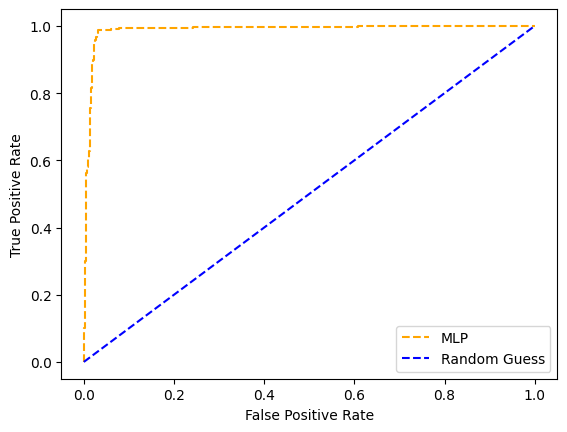

In [15]:
# ROC Curve (binary classification: STAR vs GALAXY)
ytest_bin = []
for value in ytest:
    if value == "GALAXY":
        ytest_bin.append(0)
    elif value == "STAR":
        ytest_bin.append(1)

fpr2, tpr2, threshold = roc_curve(ytest_bin, model.predict_proba(Xtest)[:,1])
random_probs = [0 for _ in range(len(ytest_bin))]
p_fpr, p_tpr, _ = roc_curve(ytest_bin, random_probs, pos_label=1)

plt.plot(fpr2, tpr2, linestyle='--', color='orange', label='MLP')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()
